# 05 Model Comparison: Transformer vs. LSTM

Dieses Notebook lädt automatisch die **neuesten Trainingsergebnisse** beider Modelle und stellt sie gegenüber.

**Vergleichsbasis:**
*   **Test-Zeitraum:** 2025-01-01 bis 2025-12-31
*   **Daten:** Identische Features & Zeitreihen
*   **Metriken:** Accuracy, ROC AUC, MCC

In [1]:
import torch
import pandas as pd
import numpy as np
import json
import pickle
import sys
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score

# Root Setup
ROOT = Path("..").resolve()
sys.path.append(str(ROOT))
from finance_transformer.model import TimeSeriesTransformer

print("Libraries loaded.")

Libraries loaded.


In [2]:
# === 1. LSTM ERGEBNISSE LADEN ===
# Wir suchen automatisch den neuesten '_lstm' Ordner im LSTM/results Verzeichnis
LSTM_RESULTS_ROOT = Path("../../LSTM/results").resolve()
lstm_runs = sorted(glob.glob(str(LSTM_RESULTS_ROOT / "*_lstm")), key=os.path.getmtime)

if not lstm_runs:
    raise FileNotFoundError("Keine LSTM-Ergebnisse gefunden!")

LATEST_LSTM_DIR = Path(lstm_runs[-1])
print(f"Neuester LSTM Run: {LATEST_LSTM_DIR.name}")

with open(LATEST_LSTM_DIR / "evaluation.json", "r") as f:
    lstm_data = json.load(f)

lstm_metrics = lstm_data["metrics"]["test"]
print("LSTM Metriken geladen.")

Neuester LSTM Run: 2026-01-01_18-20-06_lstm
LSTM Metriken geladen.


In [3]:
# === 2. TRANSFORMER DATEN & MODELL LADEN ===
TRANS_RES_DIR = ROOT / "results"

# Config
with open(TRANS_RES_DIR / "config.json", "r") as f:
    cfg = json.load(f)["cfg"]

# Scaler Metadata
with open(TRANS_RES_DIR / "scaler.pkl", "rb") as f:
    sc_data = pickle.load(f)
    scaler = sc_data["scaler"]
    feat_cols = sc_data["feat_cols"]

# Daten laden (vom Shared Path)
DATA_PATH = Path("../../LSTM/data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv").resolve()
df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
df = df.dropna()
# Wir brauchen nur 2024 (für Lookback) und 2025 (für Test)
df = df[df.index >= "2024-01-01"]

# Features bauen
X_raw = df[feat_cols]
X_scaled = scaler.transform(X_raw).astype("float32")
y_raw = df["target"].values

print(f"Transformer Daten geladen: {len(df)} Zeilen.")

# Modell laden
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TimeSeriesTransformer(
    in_features=len(feat_cols), 
    d_model=cfg["d_model"], 
    nhead=cfg["nhead"], 
    num_layers=cfg["num_layers"], 
    dim_ff=cfg["dim_ff"], 
    dropout=cfg["dropout"]
).to(device)

model.load_state_dict(torch.load(TRANS_RES_DIR / "model.pt", map_location=device))
model.eval()
print("Transformer Modell geladen.")

Transformer Daten geladen: 502 Zeilen.
Transformer Modell geladen.


c:\Users\jacin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [4]:
# === 3. EVALUATION DURCHFÜHREN (2025) ===
preds, gts = [], []
idx = df.index

test_mask = (idx >= "2025-01-01") & (idx <= "2025-12-31")
seq_len = cfg["seq_len"]

print("Evaluiere Transformer auf Test-Set...")

with torch.no_grad():
    for i in range(len(df)):
        if not test_mask[i] or i < seq_len: continue
        
        window = X_scaled[i-seq_len : i]
        x_in = torch.tensor(window).unsqueeze(0).to(device)
        
        logit = model(x_in).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()
        
        preds.append(prob)
        gts.append(y_raw[i])

y_true = np.array(gts)
y_prob = np.array(preds)
y_pred = (y_prob > 0.5).astype(int)

trans_metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "roc_auc": roc_auc_score(y_true, y_prob),
    "mcc": matthews_corrcoef(y_true, y_pred)
}

print("Evaluation abgeschlossen.")

Evaluiere Transformer auf Test-Set...
Evaluation abgeschlossen.


,Metric,LSTM,Transformer,Diff (Tr - LSTM)
0,Accuracy,0.5231,0.5160,-0.0071
1,Balanced Acc,0.5094,0.5163,0.0069
2,ROC AUC,0.5082,0.5175,0.0094
3,MCC,0.0219,0.0327,0.0108


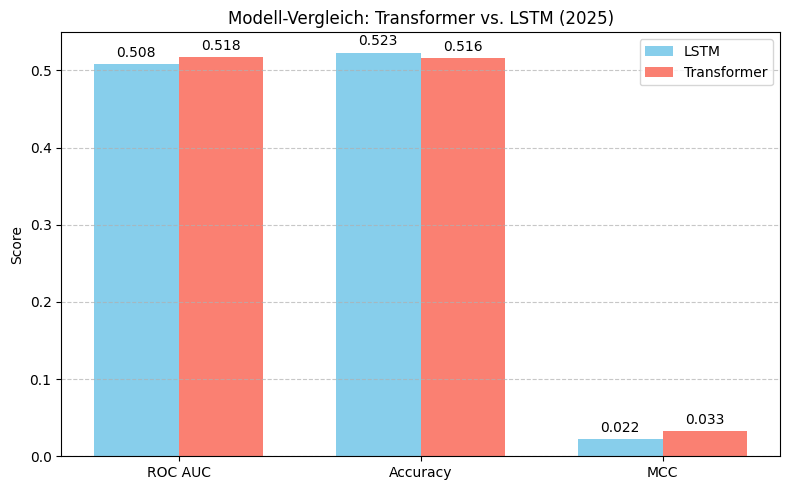

In [5]:
# === 4. VERGLEICH & VISUALISIERUNG ===

# DataFrame erstellen
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Balanced Acc", "ROC AUC", "MCC"],
    "LSTM": [
        lstm_metrics["report"]["accuracy"],
        lstm_metrics["balanced_accuracy"],
        lstm_metrics["roc_auc"],
        lstm_metrics["mcc"]
    ],
    "Transformer": [
        trans_metrics["accuracy"],
        trans_metrics["balanced_accuracy"],
        trans_metrics["roc_auc"],
        trans_metrics["mcc"]
    ]
})

comparison["Diff (Tr - LSTM)"] = comparison["Transformer"] - comparison["LSTM"]

# Tabelle anzeigen
display(comparison.round(4))

# Plotten
metrics = ["ROC AUC", "Accuracy", "MCC"]
x = np.arange(len(metrics))
width = 0.35

vals_lstm = [lstm_metrics["roc_auc"], lstm_metrics["report"]["accuracy"], lstm_metrics["mcc"]]
vals_trans = [trans_metrics["roc_auc"], trans_metrics["accuracy"], trans_metrics["mcc"]]

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, vals_lstm, width, label='LSTM', color='skyblue')
rects2 = ax.bar(x + width/2, vals_trans, width, label='Transformer', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Modell-Vergleich: Transformer vs. LSTM (2025)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Labels hinzufügen
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

plt.tight_layout()
plt.show()